# Sloane Lab XML Parser

This notebook parses the TEI XML files from the Enlightenment Architectures project, extracts the data that we want to import into the Sloane Lab knowledge base, and checks if there are any errors or inconsistencies.

#### Import libraries

In [38]:
# -*- coding: future_fstrings -*-
import os
import re
import sys
import urllib
import pandas as pd
from viapy import api
import matplotlib.pyplot as plt
from matplotlib import *
from bs4 import BeautifulSoup as Soup

%matplotlib inline

#### XML File path

In [2]:
# XML file path
XML_PATH = 'data/miscellanea.xml'

#### Function to handle catalogue numbers

In [3]:
# Function to transform the catalogue number to an integer
def cat_to_int(catnum):
    catnum = re.search('\d+', catnum)
    if catnum:
        return int(catnum.group(0))
    return None

#### Load all catalogues and their entries

In [4]:
# List of catalogues
cats = []

# Open the XML file
with open(XML_PATH) as xml_file:

    # Read the file
    xml = xml_file.read()
    
    # Parse the file
    parsed_xml = Soup(xml, 'lxml')
    
    # Create empty list of people
    people_list = []
    
    # Create empty list of places
    place_list = []
    
    # For each person in the XML list...
    for person in parsed_xml.find('listperson').find_all('person'):

        # Create dictionary with person's internal ID
        person_dict = {'id': person['xml:id']}
        
        # Find the person's external IDs
        person_ids = person.find_all('idno')
        
        # For each external ID...
        for person_id in person_ids:

            # If the type of ID is VIAF...
            if person_id['type'] == 'viaf':
                
                # Add VIAF ID to person dictionary
                person_dict['viaf'] = person_id.text 
 
            # Otherwise, print person
            else:
                print(person)
            
        # Add the dictionary to the list
        people_list.append(person_dict)
    
    # For each place in the XML list...
    for place in parsed_xml.find('listplace').find_all('place'):
        
        # Create dictionary with place's internal ID
        place_dict = {'id': place['xml:id']}

        # Find the person's external IDs
        place_ids = place.find_all('idno')
        
        # For each external ID...
        for place_id in place_ids:
            
            # If the type of ID is VIAF...
            if place_id['type'] == 'viaf':
            
                # Add VIAF ID to place dictionary
                place_dict['viaf'] = place_id.text

            # If the type of ID is GEO...
            elif place_id['type'] == 'geo':
                
                try:
                    # Extract latitude and longitude
                    lat, lon = place_id.text.split(',')
                
                    # Add latitude to place dictionary
                    place_dict['lat'] = float(lat.strip())
                
                    # Add longitude to place dictionary
                    place_dict['lon'] = float(lon.strip())
                except:
                    print(place)
                
            # Otherwise, print place
            else:
                print(place)
            
        # Add the dictionary to the list
        place_list.append(place_dict)

    # Find all catalogues in the manuscript
    catalogues = parsed_xml.find_all('div2')
    
    # For each catalogue...
    for catalogue in catalogues:
        
        # Create catalogue dictionary
        cat_dict = {}
        
        # Create list of entries
        cat_dict['entries'] = []
        
        # Get catalogue title
        cat_dict['title'] = catalogue.find('label').text
        
        # Find all entries in the catalogue
        entries = catalogue.find_all('div3')
    
        # For each entry...
        for entry in entries:
            
            # Get number of entry
            catnum = entry.find('ea:catnum').get_text() if entry.find('ea:catnum') else None
            
            # Get people
            people = entry.find_all('persname')
            
            # Get places
            places = entry.find_all('placename')
            
            # Create entry dictionary
            entry_dict = {
                'num_str': ' '.join(catnum.split()) if catnum else None,
                'num_int': cat_to_int(catnum) if catnum else None,
                'text': ' '.join(entry.text.split()),
                'people': [{'id': x['ref'].strip('#') if 'ref' in x.attrs else None, 'name': ' '.join(x.text.split())} for x in people] if people else None,
                'places': [{'id': x['ref'].strip('#') if 'ref' in x.attrs else None, 'name': ' '.join(x.text.split())} for x in places] if places else None
            }
        
            # Append entry to entry list
            cat_dict['entries'].append(entry_dict)
        
        # Append catalogue to catalogue list
        cats.append(cat_dict)

<place xml:id="Eichstadt">
<placename>Eichstadt</placename>
<idno type="viaf">124967002</idno>
<idno type="geo"> 124967002</idno>
</place>
<place xml:id="Hispaniola">
<placename>Hispaniola</placename>
<placename>wreck on the coast of Espanola</placename>
<idno type="viaf">242111207</idno>
<idno type="geo"> failed</idno>
</place>
<place xml:id="Katzenelnbogen">
<placename>Country of Catzellenbogen &amp; belonging to the Landgrave of Hesse cassell,
              northward of Mayence</placename>
<idno type="viaf">129154192</idno>
<idno type="geo"> 50.26745,†7.97322</idno>
</place>
<place xml:id="Lapland">
<placename>Lapland</placename>
<idno type="viaf">140666509 </idno>
<idno type="geo"> 67.616229 26.761877</idno>
</place>
<place xml:id="Manila">
<placename>Maniglia in the East Indies </placename>
<idno type="viaf">128902416</idno>
<idno type="geo"> 14.6042,†120.9822</idno>
</place>
<place xml:id="Melo_Island">
<placename>Melo Island</placename>
<idno type="geo"> 11.03333,†-15.21667</idn

#### How many people in the list?

In [5]:
len(people_list)

2799

#### How many places in the list?

In [6]:
len(place_list)

555

#### How many catalogues?

In [7]:
# Print number of catalogues
len(cats)

9

#### What are their titles?

In [48]:
# Print all catalogue titles
[x['title'].strip() for x in cats]

['Miscellanies.',
 'Antiquities.',
 'Impressions of Seals &c.',
 'Index. inSigilla, Sigillorum. Impressiones, &c.',
 'Pictures &c.',
 'Mathematicall instruments &c',
 'Index to the Mathematical Instruments.',
 'Agate handles &c.',
 'Agate cups botles spoons &c.']

#### What are their lengths?

In [50]:
# Compute catalogue lengths
for x in cats:
    x['length'] = len(x['entries'])

[x['length'] for x in cats]

[2335, 1376, 290, 332, 450, 60, 105, 261, 364]

#### Transform the list of catalogues into a dataframe

In [51]:
cat_df = pd.DataFrame(cats)
cat_df

,entries,length,title
0,"[{'places': [{'id': 'East_Indies', 'name': 'Ea...",2335,Miscellanies.
1,"[{'places': None, 'num_str': '-700.', 'num_int...",1376,Antiquities.
2,"[{'places': [{'id': 'Scotland', 'name': 'Scotl...",290,Impressions of Seals &c.
3,"[{'places': None, 'num_str': None, 'num_int': ...",332,"Index. inSigilla, Sigillorum. Impressiones, &c."
4,"[{'places': None, 'num_str': '-1.', 'num_int':...",450,Pictures &c.
5,"[{'places': None, 'num_str': '1.', 'num_int': ...",60,Mathematicall instruments &c
6,"[{'places': None, 'num_str': None, 'num_int': ...",105,\nIndex to the Mathematical Instruments.\n
7,"[{'places': None, 'num_str': '1.', 'num_int': ...",261,Agate handles &c.
8,"[{'places': None, 'num_str': '1.', 'num_int': ...",364,Agate cups botles spoons &c.


#### Display the lengths of the catalogues

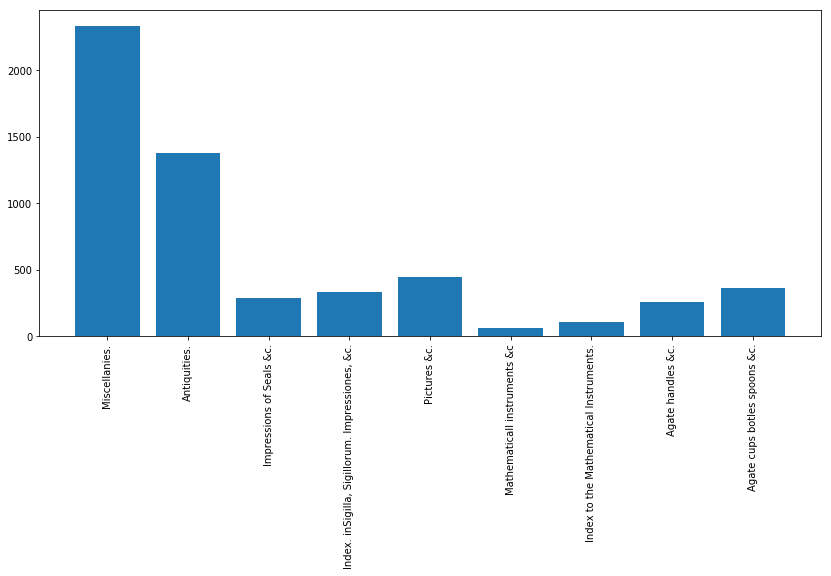

In [52]:
plt.figure(figsize=(14,6))
plt.xticks(range(30), rotation='vertical')
plt.bar(cat_df['title'],cat_df['length'])
plt.show()

#### First catalogue: Miscellanies

In [9]:
# Check first catalogue
cats[0]

{'entries': [{'num_int': 1799,
   'num_str': '-1799.',
   'people': [{'id': 'Mr._Amyand', 'name': 'Mr. Amyand'}],
   'places': [{'id': 'East_Indies', 'name': 'East Indies'}],
   'text': '-1799. A bow said to be made of a bone from East Indies given to me by Mr. Amyand 252.'},
  {'num_int': 1800,
   'num_str': '-1800.',
   'people': None,
   'places': None,
   'text': '-1800. Arrows from the same. Id. 252.'},
  {'num_int': 1801,
   'num_str': '-1801.',
   'people': [{'id': 'James_Theobalds_Esqr', 'name': 'Mr. Theobalds'}],
   'places': [{'id': 'Norway', 'name': 'Norway'}],
   'text': '-1801. A trumpet from Norway made of 2 pieces of wood about 5 foot long in form of a trumpet fastened by birch tree bark from Mr. Theobalds. 245.'},
  {'num_int': 1802,
   'num_str': '-1802.',
   'people': None,
   'places': None,
   'text': '-1802. A Chinese womans shoe. 299 b 24'},
  {'num_int': 1803,
   'num_str': '-1803.',
   'people': None,
   'places': None,
   'text': '-1803. A chinese womans girdle

#### What is the title?

In [10]:
# Print title of first catalogue
cats[0]['title']

'Miscellanies.'

#### How many catalogue entries in Miscellanies?

In [11]:
# Print number of entries in first catalogue
len(cats[0]['entries'])

2335

#### What is the first entry?

In [12]:
# Print first entry
cats[0]['entries'][0]

{'num_int': 1799,
 'num_str': '-1799.',
 'people': [{'id': 'Mr._Amyand', 'name': 'Mr. Amyand'}],
 'places': [{'id': 'East_Indies', 'name': 'East Indies'}],
 'text': '-1799. A bow said to be made of a bone from East Indies given to me by Mr. Amyand 252.'}

#### Put all the data in a dataframe

In [61]:
# Create dataframe from first catalogue
df = pd.DataFrame(cats[0]['entries'])

# Set visualisation options
pd.set_option('precision', 0)

# Print the dataframe
df

# Drop nulls
df = df.dropna(subset=['num_int'])

# Sort by entry number
df = df.sort_values(by=['num_int'])

# Print the dataframe
df

,num_int,num_str,people,places,text
245,1,No. 1.,None,None,No. 1. is for their Lines to run out on: and e...
21,1,1.,None,"[{'id': 'London', 'name': 'London'}]",1. A parcell of knives with bone hafts burnt i...
22,2,2.,None,None,2. A brush of Ostridges feathers. ✓ < 226
23,3,3.,None,None,3. A piece of the keel of a ship eat by the wo...
24,4,4.,None,"[{'id': 'Coromandel', 'name': 'Coromandel'}]",4. A shoe from Coromandel ✓ < 226. 25 X
25,5,5.,None,None,5. The same. ✓ < 226. 25.
26,6,6.,None,None,6. An ivory instrument - - 0. 1. 0 ✓ < 245
27,7,___7.,"[{'id': 'Jean_De_Fontaney', 'name': 'father Fo...","[{'id': 'China', 'name': 'China'}]",___7. A sword from China worn there by father ...
28,8,8.,None,"[{'id': 'Persia', 'name': 'Persian'}]",8. A Persian sword ? 245. Another ye same. 252.
29,9,___9.,"[{'id': 'James_Cunningham', 'name': 'Mr. Cunni...","[{'id': 'Tonkin', 'name': 'Tunquin'}]",___9. A hatt from Tunquin where it belonged to...


#### Find duplicate entries

In [14]:
# Find duplicates
df.duplicated(subset=['num_int']).value_counts()

False    2109
True       56
dtype: int64

#### Print the duplicates

In [15]:
pd.set_option ('display.max_rows', None)
df[df.duplicated(subset=['num_int'])]

,num_int,num_str,people,places,text
21,1,1.,None,"[{'id': 'London', 'name': 'London'}]",1. A parcell of knives with bone hafts burnt i...
471,204,204.,None,"[{'id': 'Canada', 'name': 'Canada'}]",204. Crin d'Orignac or hair of wt. wch. dyed t...
761,385,385*.,None,None,385*. Another in a blew Jacket & yellow Hat: y...
762,386,386.,None,None,386. Another. a Harlequin: part of ye Head bro...
1178,396,396,None,"[{'id': 'Virginia', 'name': 'Virginia'}]",396 A black b wt. the tips of the wings scalet...
810,427,427*.,None,None,427*. A turd in wax work in a straw work'd box...
940,542,-542.,None,None,-542. pendent? the moon a Spoon & a hand in je...
1358,909,-909.,None,None,-909. Yellow glasse. made of lead ?- from the ...
1359,910,-910.,"[{'id': 'Martin_Lister', 'name': 'Dr. Lister'}]",None,-910. Vitrum sublimatum ti. Cinna= =bar Vitrif...
1360,911,-911.,None,None,-911. Pieces of cast burning glasses from the ...


#### Now let's look at people

In [16]:
# Find all mentions of people
[x for x in df.explode('people')['people'] if x]

[{'id': 'Mr._Amyand', 'name': 'Mr. Amyand'},
 {'id': 'James_Theobalds_Esqr', 'name': 'Mr. Theobalds'},
 {'id': 'Mr_Roberts', 'name': 'Mr. Roberts'},
 {'id': 'MrMC', 'name': 'Mr. Mc. Cormick'},
 {'id': 'Alexander_Stuart', 'name': 'Dr. Stuart'},
 {'id': 'MrMC', 'name': 'Mr. Mc. Cormick'},
 {'id': 'Mr._Hodson', 'name': 'Mr. Hodsun'},
 {'id': 'Mr._Launce', 'name': 'Mr. Launce'},
 {'id': 'Jean_De_Fontaney', 'name': 'father Fontenay'},
 {'id': 'James_Cunningham', 'name': 'Mr. Cunningham'},
 {'id': 'Daniel_Waldo', 'name': 'Dr. Waldo'},
 {'id': 'Capt_Walker', 'name': 'Capt. Walker'},
 {'id': 'Capt_Walker', 'name': 'Capt. Walker'},
 {'id': 'Isaac_Waldron_Esqr', 'name': 'Isaac Waldron Esqr'},
 {'id': 'Abraham_Waldron', 'name': 'Abraham Waldron'},
 {'id': 'William_Courten', 'name': 'Mr. Courtens'},
 {'id': 'George_Edwards, Mr._Edwards', 'name': 'Mr. Edwards'},
 {'id': 'Richard_Middleton_Massey', 'name': 'Dr. Massy'},
 {'id': 'George_Edwards, Mr._Edwards', 'name': 'Mr. Edwards'},
 {'id': 'Peter_Co

#### How many mentions of people?

In [17]:
# Count all mentions of people
len([x for x in df.explode('people')['people'] if x])

546

#### How many actual people?

In [18]:
# Count individual people
individual_people = set([x['id'] for x in df.explode('people')['people'] if x])
len(individual_people)

296

#### How many people are not in the main list of people?

In [19]:
# Find all people that are not in the main list
people_list_ids = [x['id'] for x in people_list]
person_not_in_list = [x for x in individual_people if x not in people_list_ids]
person_not_in_list

['George_Edwards, Mr._Edwards',
 'King_James_2nd, King_James',
 'Mrs_Edwards, Mrs._Edwards',
 'Mrs_Dering, Mrs._Dering',
 'Jean_Rodoplhe_Lavater, Dr._Lavater',
 'John_Winthrop, Mr._Winthorpe',
 'William_Hanbury, William_Hanbury',
 'Charles_Lennox_Duke_of_Richmond, James_Stuart_Duke_of_Richmond',
 'Mr_Maidstone, Mr._Maidstone']

#### And if we check more thoroughly?

In [20]:
# Find all people that are not in the main list, excluding special cases
len([x for x in person_not_in_list if [y for y in x.split(',') if y.strip() not in people_list_ids]])

0

#### Now let's look at places

In [21]:
# Find all mentions of places
[x for x in df.explode('places')['places'] if x]

[{'id': 'East_Indies', 'name': 'East Indies'},
 {'id': 'Norway', 'name': 'Norway'},
 {'id': 'Lisbon', 'name': 'Lisbon'},
 {'id': 'Lisbon', 'name': 'Lisbone'},
 {'id': 'Malacca', 'name': 'Malacca'},
 {'id': 'China', 'name': 'China'},
 {'id': 'Lisbon', 'name': 'Lisbon'},
 {'id': 'Brasil', 'name': 'Brasile'},
 {'id': 'China', 'name': 'China'},
 {'id': 'Guinea', 'name': 'Guinea'},
 {'id': 'Malabar', 'name': 'Malabar'},
 {'id': 'England', 'name': 'England'},
 {'id': 'London', 'name': 'London'},
 {'id': 'Coromandel', 'name': 'Coromandel'},
 {'id': 'China', 'name': 'China'},
 {'id': 'Persia', 'name': 'Persian'},
 {'id': 'Tonkin', 'name': 'Tunquin'},
 {'id': 'China', 'name': 'China'},
 {'id': 'Suratte', 'name': 'Suratte'},
 {'id': 'New_England', 'name': 'New England'},
 {'id': 'Berbice', 'name': 'Berbices'},
 {'id': 'Surinam', 'name': 'Surinam'},
 {'id': 'West_Indies', 'name': 'West Indies'},
 {'id': 'Surinam', 'name': 'Surinam'},
 {'id': 'Guinea', 'name': 'Guinea'},
 {'id': 'Bristol', 'name':

#### How many mentions of places?

In [22]:
# Count all mentions of places
len([x for x in df.explode('places')['places'] if x])

668

#### How many actual places?

In [23]:
# Count individual places
individual_places = set([x['id'] for x in df.explode('places')['places'] if x])
len(individual_places)

181

#### How many places are not in the main list of places?

In [24]:
# Count all places that are not in the main list
place_list_ids = [x['id'] for x in place_list]
place_not_in_list = [x for x in individual_places if x not in place_list_ids]
len(place_not_in_list)

0

#### Find all VIAF IDs of people

In [25]:
people_list_viaf = sorted([int(x['viaf']) for x in people_list if 'viaf' in x])
people_list_viaf

[26221,
 29153,
 30977,
 40093,
 40220,
 42182,
 42225,
 46244,
 48609,
 60021,
 77959,
 85044,
 93909,
 108057,
 117486,
 126731,
 132112,
 155498,
 156009,
 175833,
 176192,
 194577,
 237497,
 284244,
 300140,
 361641,
 363997,
 366106,
 441684,
 774683,
 792439,
 792879,
 805714,
 805877,
 822823,
 837905,
 849367,
 895409,
 934497,
 956203,
 1263219,
 1456147,
 1499948,
 1562998,
 2319765,
 2327009,
 2331192,
 2358196,
 2378232,
 2411429,
 2474502,
 2479682,
 2495579,
 2496935,
 2508854,
 2515242,
 2519559,
 2521078,
 2546468,
 2551924,
 2556684,
 2589083,
 2604336,
 2604452,
 2735066,
 2769606,
 2788543,
 2809212,
 2818528,
 2818730,
 2821751,
 2832039,
 2832981,
 2870639,
 2900775,
 3086266,
 3265477,
 3267042,
 3393065,
 3396615,
 3544559,
 3893245,
 3908040,
 4499544,
 4791162,
 4798582,
 4805023,
 4805598,
 4822479,
 4919216,
 4919216,
 4940012,
 4940467,
 4940582,
 4945401,
 4951927,
 4956694,
 4973470,
 5017560,
 5041312,
 5046077,
 5061772,
 5065380,
 5113867,
 5168708,
 51

#### Open all VIAF IDs of people to check if they exist

In [26]:
for viaf_id in people_list_viaf:
    url = 'https://viaf.org/viaf/{}/justlinks.json'.format(viaf_id)
    print(url)
    try:
        urllib.request.urlopen(url)
    except:
        print('DOES NOT EXIST')

https://viaf.org/viaf/26221/justlinks.json
https://viaf.org/viaf/29153/justlinks.json
https://viaf.org/viaf/30977/justlinks.json
https://viaf.org/viaf/40093/justlinks.json
https://viaf.org/viaf/40220/justlinks.json
https://viaf.org/viaf/42182/justlinks.json
https://viaf.org/viaf/42225/justlinks.json
https://viaf.org/viaf/46244/justlinks.json
https://viaf.org/viaf/48609/justlinks.json
https://viaf.org/viaf/60021/justlinks.json
https://viaf.org/viaf/77959/justlinks.json
https://viaf.org/viaf/85044/justlinks.json
https://viaf.org/viaf/93909/justlinks.json
https://viaf.org/viaf/108057/justlinks.json
https://viaf.org/viaf/117486/justlinks.json
https://viaf.org/viaf/126731/justlinks.json
https://viaf.org/viaf/132112/justlinks.json
https://viaf.org/viaf/155498/justlinks.json
https://viaf.org/viaf/156009/justlinks.json
https://viaf.org/viaf/175833/justlinks.json
https://viaf.org/viaf/176192/justlinks.json
https://viaf.org/viaf/194577/justlinks.json
https://viaf.org/viaf/237497/justlinks.json
h

https://viaf.org/viaf/8814941/justlinks.json
https://viaf.org/viaf/8928748/justlinks.json
https://viaf.org/viaf/9324349/justlinks.json
https://viaf.org/viaf/9720045/justlinks.json
https://viaf.org/viaf/9722692/justlinks.json
https://viaf.org/viaf/9787916/justlinks.json
https://viaf.org/viaf/9798235/justlinks.json
https://viaf.org/viaf/9827268/justlinks.json
https://viaf.org/viaf/9837888/justlinks.json
https://viaf.org/viaf/9849392/justlinks.json
https://viaf.org/viaf/9856920/justlinks.json
https://viaf.org/viaf/9857012/justlinks.json
https://viaf.org/viaf/9865630/justlinks.json
https://viaf.org/viaf/9877713/justlinks.json
https://viaf.org/viaf/9887952/justlinks.json
https://viaf.org/viaf/9894043/justlinks.json
https://viaf.org/viaf/9926861/justlinks.json
https://viaf.org/viaf/9928566/justlinks.json
https://viaf.org/viaf/9965263/justlinks.json
https://viaf.org/viaf/9970490/justlinks.json
https://viaf.org/viaf/9979313/justlinks.json
https://viaf.org/viaf/10034259/justlinks.json
https://v

https://viaf.org/viaf/18650208/justlinks.json
https://viaf.org/viaf/18664895/justlinks.json
https://viaf.org/viaf/18897214/justlinks.json
https://viaf.org/viaf/19552454/justlinks.json
https://viaf.org/viaf/19552973/justlinks.json
https://viaf.org/viaf/19553659/justlinks.json
https://viaf.org/viaf/19556565/justlinks.json
https://viaf.org/viaf/19557125/justlinks.json
https://viaf.org/viaf/19635062/justlinks.json
https://viaf.org/viaf/19668788/justlinks.json
https://viaf.org/viaf/19687783/justlinks.json
https://viaf.org/viaf/19709327/justlinks.json
https://viaf.org/viaf/19710661/justlinks.json
https://viaf.org/viaf/19712599/justlinks.json
https://viaf.org/viaf/19715963/justlinks.json
https://viaf.org/viaf/19724806/justlinks.json
https://viaf.org/viaf/19725880/justlinks.json
https://viaf.org/viaf/19754288/justlinks.json
https://viaf.org/viaf/19790673/justlinks.json
https://viaf.org/viaf/19810665/justlinks.json
https://viaf.org/viaf/19827688/justlinks.json
https://viaf.org/viaf/19827688/jus

https://viaf.org/viaf/28625627/justlinks.json
https://viaf.org/viaf/29366429/justlinks.json
https://viaf.org/viaf/29391602/justlinks.json
https://viaf.org/viaf/29408637/justlinks.json
https://viaf.org/viaf/29436338/justlinks.json
https://viaf.org/viaf/29463840/justlinks.json
https://viaf.org/viaf/29467576/justlinks.json
https://viaf.org/viaf/29524057/justlinks.json
https://viaf.org/viaf/29541174/justlinks.json
https://viaf.org/viaf/29543710/justlinks.json
https://viaf.org/viaf/29556453/justlinks.json
https://viaf.org/viaf/29557778/justlinks.json
https://viaf.org/viaf/29564062/justlinks.json
https://viaf.org/viaf/29567630/justlinks.json
https://viaf.org/viaf/29571577/justlinks.json
https://viaf.org/viaf/29575102/justlinks.json
https://viaf.org/viaf/29581678/justlinks.json
https://viaf.org/viaf/29584945/justlinks.json
https://viaf.org/viaf/29588767/justlinks.json
https://viaf.org/viaf/29602261/justlinks.json
https://viaf.org/viaf/29630623/justlinks.json
https://viaf.org/viaf/29688630/jus

https://viaf.org/viaf/39450522/justlinks.json
https://viaf.org/viaf/39466716/justlinks.json
https://viaf.org/viaf/39475242/justlinks.json
https://viaf.org/viaf/39494028/justlinks.json
https://viaf.org/viaf/39603961/justlinks.json
https://viaf.org/viaf/39651058/justlinks.json
https://viaf.org/viaf/39671650/justlinks.json
https://viaf.org/viaf/39675309/justlinks.json
https://viaf.org/viaf/39717532/justlinks.json
https://viaf.org/viaf/39724695/justlinks.json
https://viaf.org/viaf/39728327/justlinks.json
https://viaf.org/viaf/39731051/justlinks.json
https://viaf.org/viaf/40159225/justlinks.json
https://viaf.org/viaf/40161749/justlinks.json
https://viaf.org/viaf/40176451/justlinks.json
https://viaf.org/viaf/40274712/justlinks.json
https://viaf.org/viaf/40577414/justlinks.json
https://viaf.org/viaf/40795740/justlinks.json
https://viaf.org/viaf/41706359/justlinks.json
https://viaf.org/viaf/41722742/justlinks.json
https://viaf.org/viaf/41800554/justlinks.json
https://viaf.org/viaf/41828866/jus

https://viaf.org/viaf/50023446/justlinks.json
https://viaf.org/viaf/50024557/justlinks.json
https://viaf.org/viaf/50027622/justlinks.json
https://viaf.org/viaf/50037252/justlinks.json
https://viaf.org/viaf/50071123/justlinks.json
https://viaf.org/viaf/50151830/justlinks.json
https://viaf.org/viaf/50153775/justlinks.json
https://viaf.org/viaf/50170505/justlinks.json
https://viaf.org/viaf/50171862/justlinks.json
https://viaf.org/viaf/50338444/justlinks.json
https://viaf.org/viaf/50339760/justlinks.json
https://viaf.org/viaf/50449886/justlinks.json
https://viaf.org/viaf/50645901/justlinks.json
https://viaf.org/viaf/50726614/justlinks.json
https://viaf.org/viaf/50756810/justlinks.json
https://viaf.org/viaf/51253882/justlinks.json
https://viaf.org/viaf/51529264/justlinks.json
https://viaf.org/viaf/51542802/justlinks.json
https://viaf.org/viaf/51680456/justlinks.json
https://viaf.org/viaf/51684915/justlinks.json
https://viaf.org/viaf/51696979/justlinks.json
https://viaf.org/viaf/51698379/jus

https://viaf.org/viaf/59865300/justlinks.json
https://viaf.org/viaf/59866301/justlinks.json
https://viaf.org/viaf/59876646/justlinks.json
https://viaf.org/viaf/59910506/justlinks.json
https://viaf.org/viaf/59935220/justlinks.json
https://viaf.org/viaf/59973189/justlinks.json
https://viaf.org/viaf/59989592/justlinks.json
https://viaf.org/viaf/60004252/justlinks.json
https://viaf.org/viaf/60015287/justlinks.json
https://viaf.org/viaf/60017882/justlinks.json
https://viaf.org/viaf/60023454/justlinks.json
https://viaf.org/viaf/60498491/justlinks.json
https://viaf.org/viaf/60511927/justlinks.json
https://viaf.org/viaf/61102864/justlinks.json
https://viaf.org/viaf/61108132/justlinks.json
https://viaf.org/viaf/61181686/justlinks.json
https://viaf.org/viaf/61395521/justlinks.json
https://viaf.org/viaf/61395521/justlinks.json
https://viaf.org/viaf/61421006/justlinks.json
https://viaf.org/viaf/61441922/justlinks.json
https://viaf.org/viaf/61496095/justlinks.json
https://viaf.org/viaf/61534328/jus

https://viaf.org/viaf/69281595/justlinks.json
https://viaf.org/viaf/69289986/justlinks.json
https://viaf.org/viaf/69661324/justlinks.json
https://viaf.org/viaf/69741796/justlinks.json
https://viaf.org/viaf/69821380/justlinks.json
https://viaf.org/viaf/70060010/justlinks.json
https://viaf.org/viaf/70314248/justlinks.json
https://viaf.org/viaf/70948335/justlinks.json
https://viaf.org/viaf/71238650/justlinks.json
https://viaf.org/viaf/71245595/justlinks.json
https://viaf.org/viaf/71248316/justlinks.json
https://viaf.org/viaf/71258475/justlinks.json
https://viaf.org/viaf/71267294/justlinks.json
https://viaf.org/viaf/71272966/justlinks.json
https://viaf.org/viaf/71386625/justlinks.json
https://viaf.org/viaf/71400665/justlinks.json
https://viaf.org/viaf/71405428/justlinks.json
https://viaf.org/viaf/71413882/justlinks.json
https://viaf.org/viaf/71422092/justlinks.json
https://viaf.org/viaf/71426018/justlinks.json
https://viaf.org/viaf/71427941/justlinks.json
https://viaf.org/viaf/71428126/jus

https://viaf.org/viaf/88892951/justlinks.json
https://viaf.org/viaf/88905668/justlinks.json
https://viaf.org/viaf/88984774/justlinks.json
https://viaf.org/viaf/88984774/justlinks.json
https://viaf.org/viaf/88987908/justlinks.json
https://viaf.org/viaf/89009260/justlinks.json
https://viaf.org/viaf/89010402/justlinks.json
https://viaf.org/viaf/89105442/justlinks.json
https://viaf.org/viaf/89318980/justlinks.json
https://viaf.org/viaf/89352673/justlinks.json
https://viaf.org/viaf/89354395/justlinks.json
https://viaf.org/viaf/89765469/justlinks.json
https://viaf.org/viaf/90497456/justlinks.json
https://viaf.org/viaf/90497528/justlinks.json
https://viaf.org/viaf/90770180/justlinks.json
https://viaf.org/viaf/90941241/justlinks.json
https://viaf.org/viaf/91115259/justlinks.json
https://viaf.org/viaf/91664246/justlinks.json
https://viaf.org/viaf/91750131/justlinks.json
https://viaf.org/viaf/93125901/justlinks.json
https://viaf.org/viaf/93363329/justlinks.json
https://viaf.org/viaf/93583902/jus

https://viaf.org/viaf/247246566/justlinks.json
https://viaf.org/viaf/248203740/justlinks.json
https://viaf.org/viaf/250796979/justlinks.json
https://viaf.org/viaf/250919692/justlinks.json
https://viaf.org/viaf/255675899/justlinks.json
https://viaf.org/viaf/259809397/justlinks.json
https://viaf.org/viaf/259857623/justlinks.json
https://viaf.org/viaf/261707238/justlinks.json
https://viaf.org/viaf/263401905/justlinks.json
https://viaf.org/viaf/264888804/justlinks.json
https://viaf.org/viaf/266081375/justlinks.json
https://viaf.org/viaf/266081375/justlinks.json
https://viaf.org/viaf/266222116/justlinks.json
https://viaf.org/viaf/268706743/justlinks.json
https://viaf.org/viaf/276018980/justlinks.json
https://viaf.org/viaf/278479781/justlinks.json
https://viaf.org/viaf/278824281/justlinks.json
https://viaf.org/viaf/279541491/justlinks.json
https://viaf.org/viaf/279985506/justlinks.json
https://viaf.org/viaf/281220600/justlinks.json
https://viaf.org/viaf/281438691/justlinks.json
https://viaf.

#### Only one ID doesn't match. What is the name of the person?

In [27]:
[x for x in people_list if 'viaf' in x and int(x['viaf']) == 10760478][0]

{'id': 'Charles_Montigny', 'viaf': '10760478'}

#### Find all VIAF IDs of places

In [28]:
place_list_viaf = []

for x in place_list:
    if 'viaf' in x:
        try:
            place_list_viaf.append(int(x['viaf']))
        except:
            print(x)
    
place_list_viaf.sort()

{'lat': 51.35, 'lon': 1.383333, 'id': 'Isle_Thanet', 'viaf': '8.74E+21'}
{'id': 'Portobelo', 'viaf': ' '}
{'lat': -35.666667, 'lon': -55.783333, 'id': 'Rio_Plata', 'viaf': '1.14603E+18'}
{'id': 'Troy', 'viaf': '1.11454E+19'}


#### Open all VIAF IDs of places to check if they exist

In [ ]:
for viaf_id in place_list_viaf:
    url = 'https://viaf.org/viaf/{}/justlinks.json'.format(viaf_id)
    print(url)
    try:
        urllib.request.urlopen(url)
    except:
        print('DOES NOT EXIST')

https://viaf.org/viaf/122530980/justlinks.json
https://viaf.org/viaf/123091922/justlinks.json
https://viaf.org/viaf/123119883/justlinks.json
https://viaf.org/viaf/123121838/justlinks.json
https://viaf.org/viaf/123125090/justlinks.json
https://viaf.org/viaf/123218997/justlinks.json
https://viaf.org/viaf/123218997/justlinks.json
https://viaf.org/viaf/123310773/justlinks.json
https://viaf.org/viaf/123433385/justlinks.json
https://viaf.org/viaf/123608439/justlinks.json
https://viaf.org/viaf/123896014/justlinks.json
https://viaf.org/viaf/123902398/justlinks.json
https://viaf.org/viaf/124213732/justlinks.json
https://viaf.org/viaf/124272308/justlinks.json
https://viaf.org/viaf/124281406/justlinks.json
https://viaf.org/viaf/124281423/justlinks.json
https://viaf.org/viaf/124312582/justlinks.json
https://viaf.org/viaf/124321959/justlinks.json
https://viaf.org/viaf/124322655/justlinks.json
https://viaf.org/viaf/124330404/justlinks.json
https://viaf.org/viaf/124357912/justlinks.json
https://viaf.

https://viaf.org/viaf/141595502/justlinks.json
https://viaf.org/viaf/141898513/justlinks.json
https://viaf.org/viaf/141926311/justlinks.json
https://viaf.org/viaf/141936652/justlinks.json
https://viaf.org/viaf/141937103/justlinks.json
https://viaf.org/viaf/141952272/justlinks.json
https://viaf.org/viaf/141968767/justlinks.json
https://viaf.org/viaf/142524829/justlinks.json
https://viaf.org/viaf/142803650/justlinks.json
https://viaf.org/viaf/142985214/justlinks.json
https://viaf.org/viaf/143072237/justlinks.json
https://viaf.org/viaf/143074613/justlinks.json
https://viaf.org/viaf/143083976/justlinks.json
https://viaf.org/viaf/143316992/justlinks.json
https://viaf.org/viaf/143323430/justlinks.json
https://viaf.org/viaf/143649512/justlinks.json
https://viaf.org/viaf/144203711/justlinks.json
https://viaf.org/viaf/144253584/justlinks.json
https://viaf.org/viaf/144267190/justlinks.json
https://viaf.org/viaf/144294767/justlinks.json
https://viaf.org/viaf/144323980/justlinks.json
https://viaf.

DOES NOT EXIST
https://viaf.org/viaf/308211225/justlinks.json
DOES NOT EXIST
https://viaf.org/viaf/308719648/justlinks.json
DOES NOT EXIST
https://viaf.org/viaf/308719648/justlinks.json
DOES NOT EXIST
https://viaf.org/viaf/308737817/justlinks.json
DOES NOT EXIST
https://viaf.org/viaf/309644416/justlinks.json
DOES NOT EXIST
https://viaf.org/viaf/311114459/justlinks.json
DOES NOT EXIST
https://viaf.org/viaf/312657476/justlinks.json
DOES NOT EXIST
https://viaf.org/viaf/312793147/justlinks.json
DOES NOT EXIST
https://viaf.org/viaf/315124935/justlinks.json
DOES NOT EXIST
https://viaf.org/viaf/315125202/justlinks.json
DOES NOT EXIST
https://viaf.org/viaf/315126463/justlinks.json
DOES NOT EXIST
https://viaf.org/viaf/315126548/justlinks.json
DOES NOT EXIST
https://viaf.org/viaf/315126791/justlinks.json
DOES NOT EXIST
https://viaf.org/viaf/315128562/justlinks.json
DOES NOT EXIST
https://viaf.org/viaf/315129048/justlinks.json
DOES NOT EXIST
https://viaf.org/viaf/315132541/justlinks.json
DOES NOT

#### Only one ID doesn't match. What is the name of the place?

In [ ]:
[x for x in place_list if 'viaf' in x and x['viaf'] == '135974051'][0]

{'id': 'Yorkshire_Outhorn',
 'lat': 53.93264,
 'lon': -1.28712,
 'viaf': '135974051'}

#### What is the distribution of all places in the main list?

In [31]:
from mapboxgl.utils import *
from mapboxgl.viz import *

places_with_coords = pd.DataFrame(place_list).dropna(subset=['lat', 'lon'])

geo = df_to_geojson(places_with_coords, lat='lat', lon='lon', precision=3)

token = 'pk.eyJ1IjoibWV0aWxsaSIsImEiOiJjbDB2c2IydzUxN3B5M2lxZHBpbDYxZmw2In0.buJ8OEPbHtUBg8mqHNNp7A'

color_breaks = [0,10,100,1000,10000]
color_stops = create_color_stops(color_breaks, colors='RdPu')

viz = CircleViz(geo, access_token=token, 
                radius = 3, center = (places_with_coords.lon.mean(), places_with_coords.lat.mean()), 
                zoom = 2,
                color_stops=color_stops,
                label_color = '#69F0AE',
                color_default='#DD00DD',
                stroke_color='#ffffff')
viz.show()

/home/dani/.local/lib/python3.5/site-packages/IPython/core/display.py:701: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


#### What is the distribution of places in the Miscellanies?

In [32]:
places_with_coords = places_with_coords[places_with_coords['id'].isin(individual_places)] 

geo = df_to_geojson(places_with_coords, lat='lat', lon='lon', precision=3)

viz = CircleViz(geo, access_token=token, 
                radius = 3, center = (58, 33), 
                zoom = 2,
                color_stops=color_stops,
                label_color = '#69F0AE',
                color_default='#DD00DD',
                stroke_color='#ffffff')
viz.show()

#### What places are mentioned the most?

In [33]:
plc = pd.DataFrame([x for x in df.explode('places')['places'].dropna()])
plc = plc.groupby(['id'])['id'].count().sort_values(ascending=False).to_frame()
plc = plc.rename(columns = {'id':'count'})
plc

,count
id,
China,98
Japan,52
East_Indies,44
Turkey,28
Guinea,17
Jamaica,14
Persia,13
New_England,13
West_Indies,13


#### Let's plot the places on a bar chart

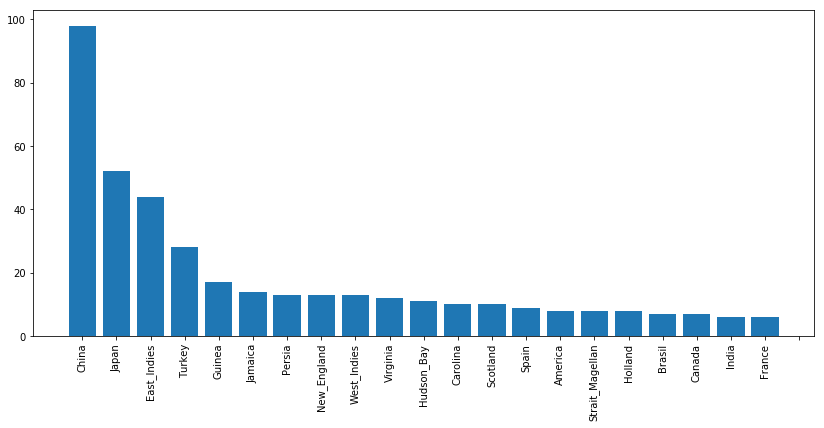

In [34]:
plt.figure(figsize=(14,6))
plt.xticks(range(30), rotation='vertical')
plc_filtered = plc[plc['count'] > 5]
plt.bar(plc_filtered.index,plc_filtered['count'])
plt.show()

#### Let's make a better map

In [35]:
places_with_coords_count = places_with_coords.join(plc, on='id', how='left')
places_with_coords_count.sort_values(by='count', ascending=False)

geo = df_to_geojson(places_with_coords_count, lat='lat', lon='lon', precision=3)

viz = GraduatedCircleViz(geo, access_token=token, 
                center = (58, 33),
                zoom = 2,
                radius_property='count',
                radius_stops=create_radius_stops([0, 5, 10, 20, 40, 60, 80, 100], 0.5, 30),
                color_stops=color_stops,
                label_color = '#69F0AE',
                color_default='#DD00DD',
                stroke_color='#ffffff')
viz.show()

In [36]:
prs = pd.DataFrame([x for x in df.explode('people')['people'].dropna()])
prs = prs.groupby(['id'])['id'].count().sort_values(ascending=False).to_frame()
prs = prs.rename(columns = {'id':'count'})
prs

,count
id,
Dr._Brown,39
James_Petiver,30
Alexander_Brown,12
Daniel_Waldo,11
Mr._Bell,9
Dr._Kempfer,9
Richard_Middleton_Massey,8
Robert_Hooke,6
Patrick_Adair,6


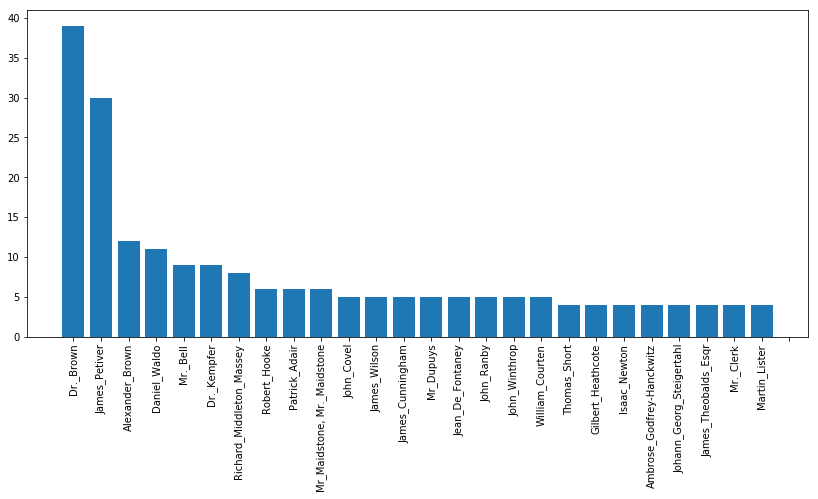

In [37]:
from matplotlib import *
%matplotlib inline

plt.figure(figsize=(14,6))
plt.xticks(range(30), rotation='vertical')
prs_filtered = prs[prs['count'] > 3]
plt.bar(prs_filtered.index,prs_filtered['count'])
plt.show()

#### Second catalogue: Antiquities

In [53]:
# Check second catalogue
cats[1]

{'entries': [{'num_int': 700,
   'num_str': '-700.',
   'people': [{'id': 'Cardinal_Gualtieri', 'name': 'Cardinall Gualtieris'}],
   'places': None,
   'text': '-700. The figure of an old bearded man in terra cotta Ægyptian from Cardinall Gualtieris collection. Vid. 287. 216. m'},
  {'num_int': 701,
   'num_str': '-701.',
   'people': None,
   'places': None,
   'text': '-701. A varietie of the same. Id. 216. m'},
  {'num_int': 702,
   'num_str': '-702.',
   'people': None,
   'places': None,
   'text': '-702. _____ in white earthen ware. Id. 216. m'},
  {'num_int': 703,
   'num_str': '-703.',
   'people': None,
   'places': None,
   'text': '-703. _____ blew earthen ware. Id. 216. m'},
  {'num_int': 704,
   'num_str': '-704.',
   'people': None,
   'places': None,
   'text': '-704. The figure of a young man in blew earthen ware. Id.'},
  {'num_int': 705,
   'num_str': '-705.',
   'people': None,
   'places': None,
   'text': '-705. _____ terra cotta. Id.'},
  {'num_int': 706,
   'num_

#### What is the title?

In [54]:
# Print title of first catalogue
cats[1]['title']

'Antiquities.'

#### What is the length?

In [55]:
# Print title of first catalogue
len(cats[1]['entries'])

1376

#### What is the first entry?

In [57]:
# Print first entry
cats[1]['entries'][1]

{'num_int': 701,
 'num_str': '-701.',
 'people': None,
 'places': None,
 'text': '-701. A varietie of the same. Id. 216. m'}

#### Put the second catalogue in a data frame

In [59]:
# Create dataframe from first catalogue
df2 = pd.DataFrame(cats[1]['entries'])

# Set visualisation options
pd.set_option('precision', 0)

# Print the dataframe
df2

# Drop nulls
df2 = df.dropna(subset=['num_int'])

# Sort by entry number
df2 = df.sort_values(by=['num_int'])

# Print the dataframe
df2

,num_int,num_str,people,places,text
704,1,1,None,None,1 A small box made of the same Sycamore as the...
891,1,1,None,"[{'id': 'Egypt', 'name': 'Egyptian'}]",1 A Small box made of the same Sycamore as the...
1036,1,1,None,None,"1 A Small bifront bust, the head red marble 14 L"
1067,1,1,None,"[{'id': 'Rome', 'name': 'Rome'}]","1 Two large jars, found in the Baths of Titus ..."
1071,1,1,"[{'id': 'Richard_Mead', 'name': 'Dr. Mead'}]","[{'id': 'Egypt', 'name': 'Egyptian'}]","1 Two Egyptian Scarabei, formerly Dr. Meads se..."
884,1,1,None,None,1 Eleven earthen models of mummies or Dei tute...
743,1,1,None,None,"1 Osiris, with a Mitre on his head, in the for..."
942,1,1,None,None,1 Three figures of Osiris of different sizes 13 K
831,1,1,"[{'id': 'William_Lethieullier', 'name': 'Colon...",None,"1 Osiris with his attributes, like those befor..."
31,1,-1,None,None,-1 A Roman stone weight wt. 4 points on its to...


#### Find duplicate entries

In [60]:
# Find duplicates
df2.duplicated(subset=['num_int']).value_counts()

False    1128
True      151
dtype: int64